# Credit Card Fraud Detection

We obtain credit card data where each datapoint represents a specific transaction. Due to privacy concerns, a PCA is performed, and we are only given 28 dimensions, in addition to two quantitative variables. We wish to build a model that will predict whether a particular transaction was fraudulent or not.

Almost everyone uses a credit card nowadays, and security is a very important issue to both the consumers and the credit card companies. Fraudulent transactions can really disrupt a consumer's finances and day-to-day life. A good predictor can automatically decide whether a transaction is fraudulent, without having to cause too much trouble on the consumer's part.

As we will see, the data is highly unbalanced, so using accuracy might lead to a model that simply predicts that all transactions are not fraud. We probably want to focus more on recall that precision, since fraudulent transactions are very rare, and a false positive case is usually easy to resolve. Of course, we shouldn't bother consumers with too many false cases of credit card fraud. We will look both at the ROC curve and precision-recall curve, but the latter may be more useful due to the imbalanced nature of the dataset.

### Dataset:
This is a Kaggle project, so the data can be found here: https://www.kaggle.com/mlg-ulb/creditcardfraud. 

There are two quantitative variables, `time` and `Amount`, where `time` is the number of seconds since the first transaction in the dataset (`time = 0`). `Amount` is the dollar amount of the transaction. `Class` is a binary variable that indicates whether a particular transaction was fraud or not. The rest of the variables, `V1`-`V28`, are the resulting dimensions after a PCA was performed on the original data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploratory Analysis

In [3]:
desc = data.describe()
desc

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We see that there are 284,807 rows in the dataset. The last transaction in this dataset took place 172,792 seconds, about 48 days, after the first transaction in this dataset. The other explanatory quantitative variable is `Amount`, whose mean is 88 dollars and median is 22 dollars. Furthermore, all the other variables which correspond to principal components seem to be standardized: mean is close to zero, and standard deviation is close to 1. Let's quickly check for any missing variables.

In [4]:
# Check for missing data
for var in data.columns:
    if len(data[data[var].isnull()]) > 0:
        print(var)

Since nothing printed, this means that there are no missing data!

We know that this dataset is unbalanced. Let us see exactly the distribution of the data between fraud/not fraud. We see that only about 0.17% of the credit card transactions in this dataset are fraud! This mirrors reality: security is a very important issue and is continuously being improved; barely anyone ever makes a fraudulent transaction. 

In [5]:
n_fraud = len(data[data['Class'] == 1])
print('Number of Frauds in Dataset:', n_fraud)
print('Fraud:', len(data[data['Class'] == 1]) / len(data))
print('Not fraud:', len(data[data['Class'] == 0]) / len(data))

Number of Frauds in Dataset: 492
Fraud: 0.001727485630620034
Not fraud: 0.9982725143693799


For completeness, let's look at the distribution of the time variable. Since our dataset looks at transactions over a 48-day period, there is perhaps a periodic trend in the number of transactions over time, with a period of about 100,000 seconds, or about 27 days. However, we don't know much more about the data, i.e., perhaps this is a subset of credit card transactions so this periodic trend is only present in this case.

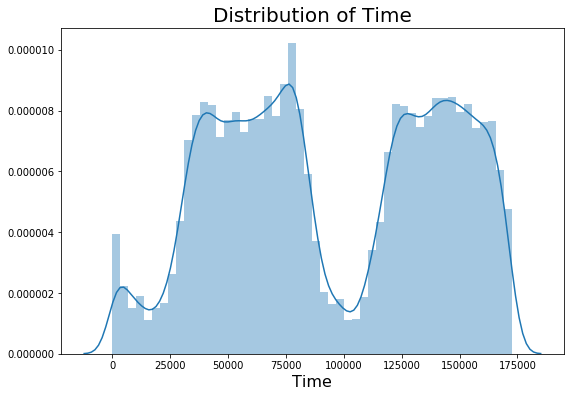

In [6]:
plt.figure(figsize=(9, 6))
plt.xlabel('Time', fontsize=16)
plt.title('Distribution of Time', fontsize=20)
sns.distplot(data['Time']);

Let's now take a look at the distribution of `Time` based on whether the transaction was fraud or not. To do this, we will make a violin plot. We see that the distributions are very similar: later we will judge from a correlation plot to determine if we shall keep this variable to use in our model.

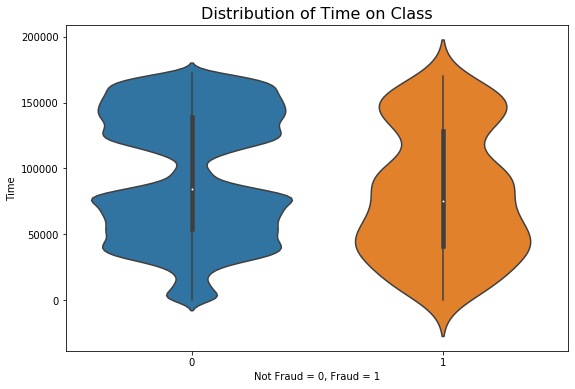

In [7]:
plt.figure(figsize=(9, 6))
plt.title('Distribution of Time on Class', fontsize=16)
sns.violinplot(x='Class', y='Time', data=data)
plt.xlabel('Not Fraud = 0, Fraud = 1');

Below is a boxplot of the `Amount` values. We see that it is highly skewed to the right, with the vast majority of transaction amounts close to zero. In fact, about 99% of the transactions in this dataset were less than 1000 dollars in amount.

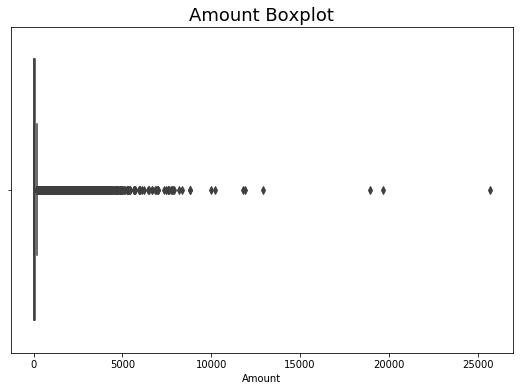

In [8]:
plt.figure(figsize=(9, 6))
plt.title('Amount Boxplot', fontsize=18)
sns.boxplot(data['Amount']);

In [9]:
# How many transactions were bigger than 1000 dollars?
print("Number of transactions bigger than 1000:", np.sum(data['Amount'] > 1000))
print("Fraction of transactions bigger than 1000:", np.sum(data['Amount'] > 1000) / len(data))

Number of transactions bigger than 1000: 2940
Fraction of transactions bigger than 1000: 0.010322779987851423


## Baseline Logistic Regression

A popular and effective technique in order to deal with such an imbalanced dataset is to perform undersampling: typical machine learning algorithms will not perform well on a dataset where 99.8% percent of the data are in the negative class. In fact, in this case, a useful baseline is to perform logistic regression on the original dataset.

In [10]:
# First, let's divide our data into training, validation, and test sets
from sklearn.model_selection import train_test_split

train, val_test = train_test_split(data, train_size=0.6, test_size=0.4, random_state=0)
validation, test = train_test_split(val_test, train_size=0.5, test_size=0.5, random_state=0)
print('Train-shape:', train.shape, 'Validation-shape:', validation.shape)

Train-shape: (170884, 31) Validation-shape: (56961, 31)


In [11]:
# We have to normalize the time and amount variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
time_amt = ['Time', 'Amount']
pcs = ['V'+str(i) for i in range(1,29)]
scaler.fit(train[time_amt])

def unbalanced_design_matrix(df):
    scaled = df[time_amt].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert numerical variables to standard units
    return pd.concat([scaled, df[pcs]], axis=1)

In [12]:
X_train, y_train = unbalanced_design_matrix(train), train['Class']
X_val, y_val = unbalanced_design_matrix(validation), validation['Class']
X_test, y_test = unbalanced_design_matrix(test), test['Class']
X_train.head(100)

,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
59047,-0.972223,-0.193419,1.412600,-1.126481,0.769823,-0.989608,-1.786631,-0.784095,-0.970396,-0.237039,...,0.006248,-0.231025,-0.205919,0.017792,-0.034302,0.768072,0.530205,-0.128744,0.051052,0.028766
249388,1.254119,-0.340674,-0.195457,1.203437,0.093016,0.881471,0.966096,-0.597060,1.277143,-0.139324,...,1.013858,0.058876,0.171365,0.782775,-0.293318,0.032989,-0.018812,-0.397271,0.435604,0.234196
209679,0.901896,0.921211,1.489838,-1.878344,-0.818912,-0.166904,-1.315812,-0.133650,-0.573227,0.030370,...,-0.452403,-0.062737,-0.390032,-1.304630,0.157790,-0.518679,-0.680248,-0.685603,-0.013874,0.010068
77120,-0.798966,7.191808,-4.868190,-7.675231,-1.319904,-1.697120,6.188912,-0.193839,-7.037926,-1.889607,...,-1.769975,3.728925,-0.011464,-2.070683,-13.458938,1.756353,-2.325517,-0.610821,0.292135,0.908701
139325,-0.247097,4.327861,-1.047580,-4.326320,-0.376047,-0.436771,-2.388023,0.157283,0.637982,-0.047648,...,0.167343,2.188855,0.894630,0.203169,-1.066856,0.353260,-0.087154,-0.006810,-0.162687,0.210510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276262,1.519555,-0.265581,-2.952994,-1.824516,0.359597,-0.764571,2.734655,3.952105,-1.629640,1.615446,...,-0.259063,-0.550307,-0.255501,0.414575,0.867611,0.675507,0.873748,0.779119,0.091631,-0.482405
166601,0.491907,-0.259679,-0.485210,0.344235,0.221036,-0.376490,0.523579,-0.191886,0.458142,-0.120024,...,0.085290,-0.393747,0.410211,1.543127,-0.274449,0.822912,-0.655752,-0.208407,-0.076853,0.282545
65737,-0.907970,-0.335708,1.410134,-0.594223,0.526813,-0.646531,-1.327381,-1.102720,-0.711772,-0.058902,...,0.625307,-0.089450,-0.124381,-0.590389,0.166563,0.306337,0.150430,-0.473381,-0.004932,0.017185
116606,-0.431306,0.540659,-0.981988,0.576658,-0.029528,-0.785391,-0.392180,-0.556021,1.427904,0.128512,...,-0.154414,0.450837,0.164154,0.253027,0.386842,-0.054459,-0.264299,0.857956,0.122012,0.173873


In [17]:
# Let's now perform logistic regression
from sklearn.linear_model import LogisticRegression

classifier_base = LogisticRegression(random_state=0)
classifier_base.fit(X_train, y_train)
classifications = classifier_base.predict(X_val)

print("Number of fraudulent cases in test set:", np.sum(y_val))
print("Number of predicted fraudulent cases:", np.sum(classifications))

/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Number of fraudulent cases in test set: 90
Number of predicted fraudulent cases: 57


Now we will measure the performance of this model through various ways. First, we will take a look at the ROC and precision-recall curves.

In [21]:
from sklearn import metrics

def curve_eval(y_true, probs, title_addition=""):
    """This function plots both the ROC and precision-recall curves for given 
       class values and predicted probabilities. They must both be one-dimensional
       vectors of the same shape."""
    
    # ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, probs)
    plt.figure(figsize=(9,6))
    plt.plot(fpr, tpr)
    plt.title("ROC curve" + " " + title_addition, fontsize=18)
    plt.show()
    
    # Precision-recall curve
    precision, recall, _ = metrics.precision_recall_curve(y_true, probs)
    plt.figure(figsize=(9,6))
    plt.plot(recall, precision)
    plt.title("Precision-recall curve" + " " + title_addition, fontsize=18)
    plt.show()
    
    # Give area-under-the-curve scores
    print("AUC for ROC:", metrics.auc(fpr, tpr))
    print("AUC for precision-recall:", metrics.auc(recall, precision))

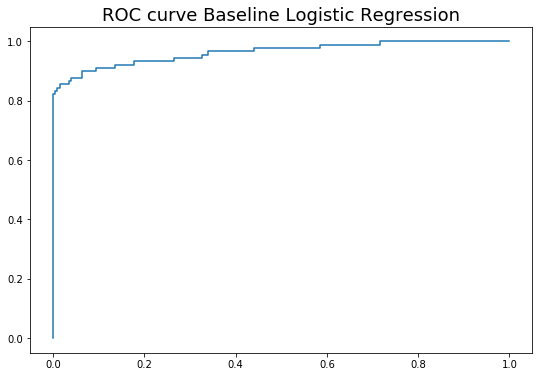

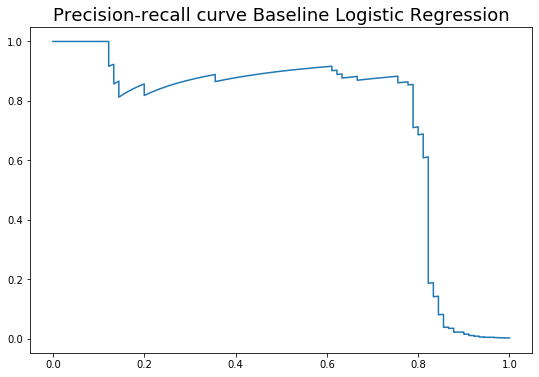

AUC for ROC: 0.9631251233297972
AUC for precision-recall: 0.7354801781816164


In [22]:
probs = classifier_base.predict_proba(X_val)
curve_eval(y_val, probs[:,1], title_addition="Baseline Logistic Regression")

From above, we notice that the ROC curve suggests that this model is actually quite good; however, the precision-recall curve shows that our classifier can definitely improve quite a bit. Indeed, below is a confusion matrix. In the test set, we know of $90$ fraudulent transactions, of which the classifier was able to detect $52$. On the other hand, of the $57$ times we predicted a fraudulent case, $5$ of them were not fraud. Thus:

$$\text{Baseline Performance:}$$

$$\text{Precision}=\frac{52}{57}=91.2\%$$

$$\text{Recall}=\frac{52}{90}=57.8\%$$

This is because the ROC curve, similar to accuracy, measures performance for __both__ classes, while the precision-recall curve focuses on performance for the positive, or fraudulent, class. Since we prefer to identify fraudulent cases, unfortunately this performance is not too good, as the recall in this case is too close to 50% (random classifier).

In [92]:
def make_confusion_matrix(y_true, preds):
    cf_mat = metrics.confusion_matrix(y_true, preds)
    df_cf_mat = pd.DataFrame(cf_mat)
    plt.figure(figsize = (9,7))
    sns.heatmap(df_cf_mat, annot=True, fmt="d", annot_kws={'size':20})
    plt.xticks([0.5, 1.5],labels=[0, 1])
    plt.yticks([0, 2],labels=[0, 1])
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title('Confusion Matrix', fontsize=20)
    plt.show()

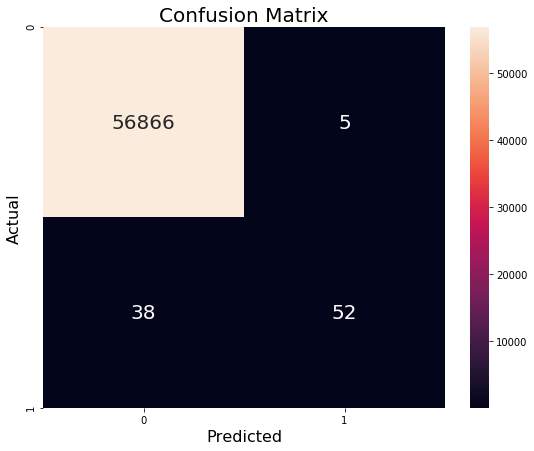

In [93]:
make_confusion_matrix(y_val, classifications)

## Feature Selection and Undersampling

The method of undersampling has become more popular in this current age of "big data." In the past, a popular technique was oversampling because collecting large amounts of data was indeed an issue. With too much data, particularly too much data in the majority class, this can be a nuisance. The idea is quite simple: randomly get rid of enough data in the majority class so that the resulting dataset is balanced. Note that this introduces bias since we train our model on only a subset of our entire dataset.

In [24]:
# Undersampling
n_fraud = len(train[train['Class'] == 1])
class0_samples = train[train['Class'] == 0].sample(n=n_fraud, random_state=0)

# Append to all fraud samples
frauds = train[train['Class'] == 1]
train_u = pd.concat([frauds, class0_samples], axis=0)
train_u

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
18466,29526.0,1.102804,2.829168,-3.932870,4.707691,2.937967,-1.800904,1.672734,-0.300240,-2.783011,...,-0.106994,-0.250050,-0.521627,-0.448950,1.291646,0.516327,0.009146,0.153318,0.68,1
50537,44532.0,-0.234922,0.355413,1.972183,-1.255593,-0.681387,-0.665732,0.059110,-0.003153,1.122451,...,0.220670,0.912107,-0.286338,0.451208,0.188315,-0.531846,0.123185,0.039581,1.00,1
150677,93879.0,-13.086519,7.352148,-18.256576,10.648505,-11.731476,-3.659167,-14.873658,8.810473,-5.418204,...,2.761157,-0.266162,-0.412861,0.519952,-0.743909,-0.167808,-2.498300,-0.711066,30.31,1
95534,65358.0,1.193916,-0.571085,0.742522,-0.014588,-0.624561,0.832162,-0.833350,0.272897,1.169425,...,-0.049502,0.207265,-0.265272,-0.679294,0.511812,1.246604,-0.028671,-0.006112,31.91,1
15225,26585.0,-19.856322,12.095893,-22.464083,6.115541,-15.148022,-4.346724,-15.648507,13.276805,-3.974162,...,1.750730,-1.409636,-0.809809,0.121397,1.350300,-0.224292,1.597621,0.476920,99.99,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46602,42852.0,1.482121,-1.397533,-1.135031,-2.349665,0.912676,3.403611,-1.453708,0.779990,-1.778852,...,-0.414824,-0.956024,0.014166,0.975786,0.510790,-0.289236,0.030440,0.021079,54.23,0
268282,163147.0,1.774139,-0.571971,0.010043,1.243734,-0.761922,0.267853,-0.832498,0.250957,1.056642,...,0.141768,0.366443,0.151679,-0.459274,-0.357607,-0.732692,0.059837,-0.022578,76.00,0
73021,54942.0,0.842692,-0.515093,1.145420,1.417123,-1.211701,-0.157417,-0.541751,0.229793,0.738211,...,0.212570,0.272371,-0.033182,0.338963,0.103180,-0.359291,0.039894,0.060042,144.00,0
246212,153082.0,1.996607,0.070629,-1.620084,0.343304,0.398532,-0.574251,0.072089,-0.069104,0.240498,...,-0.292509,-0.790769,0.351421,0.606877,-0.334396,0.147945,-0.065371,-0.038416,8.99,0


Let's now perform feature selection to extract only the features that can best predict whether a transaction was fraudulent or not. To do this, we make a correlation heatmap and visually pick out the features that are most negatively/positively correlated with the `Class` variable.

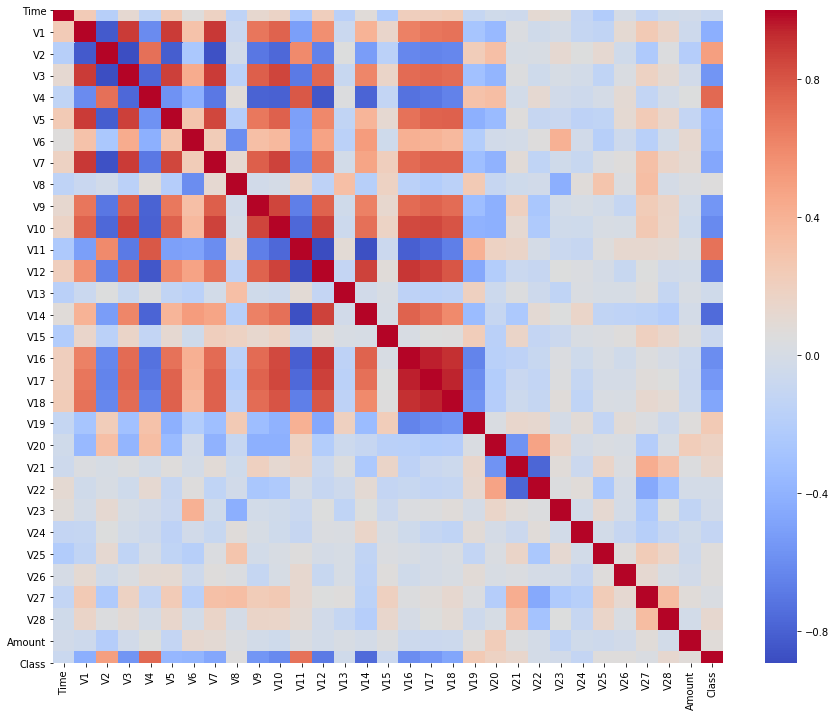

In [25]:
# Feature selection
# Make correlation heatmap to select the columns that are most positively/negatively correlated with
# whether the transaction was fraud or not
plt.figure(figsize=(15, 12))
sns.heatmap(train_u.corr(), cmap='coolwarm');

Below, we pick out the most effective explanatory variables visually.

In [26]:
# We can just do this visually
# Negatively correlated variables:
neg_vars = ['V1', 'V3', 'V5', 'V6', 'V7', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V18']
# Positively correlated variables:
pos_vars = ['V2', 'V4', 'V11']

def design_matrix(df):
    return df[neg_vars + pos_vars]

Let's see some boxplots of some of these variables by fraud/not fraud. Indeed, these boxplots represent the correlations we see in the heatmap. For example, values for `V1` on average tend to be lower for fraudulent transactions than non-fraudulent transactions. Similarly, values for `V2` tend to be higher for frauds than non-frauds.

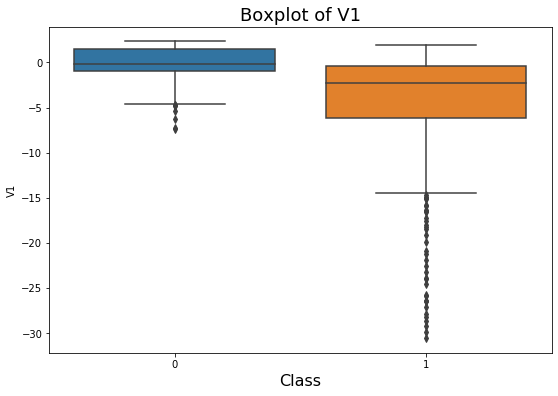

In [27]:
# V1
plt.figure(figsize=(9,6))
sns.boxplot(x='Class', y='V1', data=train_u)
plt.xlabel('Class', fontsize=16)
plt.title('Boxplot of V1', fontsize=18);

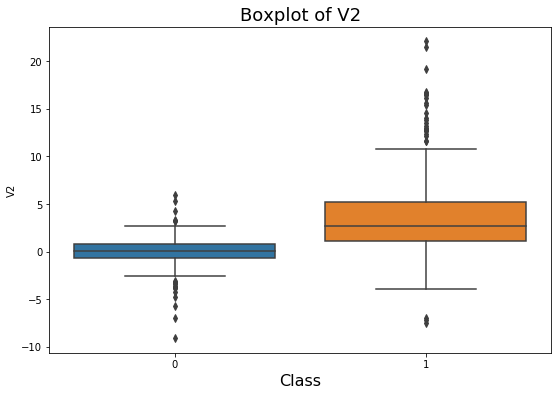

In [28]:
# V2
plt.figure(figsize=(9,6))
sns.boxplot(x='Class', y='V2', data=train_u)
plt.xlabel('Class', fontsize=16)
plt.title('Boxplot of V2', fontsize=18);

## Logistic Regression with Undersampling

We now try to fit a logistic regression model on the undersampled data.

In [95]:
X_train_u, y_train_u = design_matrix(train_u.drop('Class', axis=1)), train_u['Class']
XX_val = design_matrix(X_val)

clf_u = LogisticRegression(random_state=0)
clf_u.fit(X_train_u, y_train_u)
preds = clf_u.predict(XX_val)

/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [96]:
# Accuracy seems pretty good, but it is misleading!
acc_val = np.mean(preds == y_val)
print("Accuracy:", acc_val)

Accuracy: 0.9724021699057249


Again, let's plot a ROC curve and a precision-recall curve, knowing that we prefer looking at the precision-recall curve.

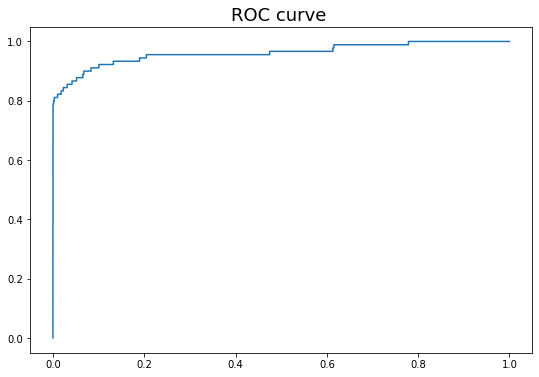

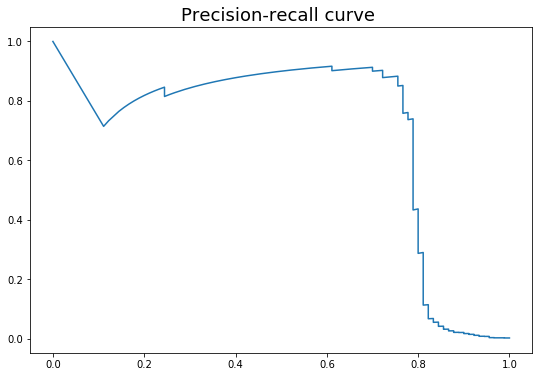

AUC for ROC: 0.9609638968503768
AUC for precision-recall: 0.6924507296811296


In [97]:
probs = clf_u.predict_proba(XX_val)
curve_eval(y_val, probs[:,1])

It seems that the AUC for the precision-recall curve actually decreased, but we indeed get similar performance looking at the top-right corner of the plot. We will use the validation set to find an optimal threshold value. From below, our recall improved quite a bit, but the precision is quite low.

$$\text{Validation With Undersampling:}$$

$$\text{Precision}=\frac{76}{76+1558}=4.65\%$$

$$\text{Recall}=\frac{76}{76+14}=84.4\%$$

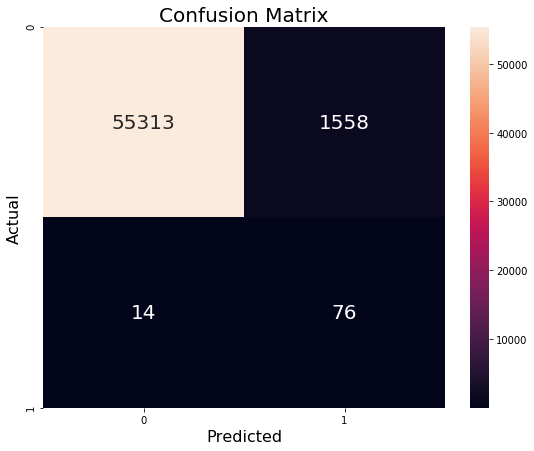

In [98]:
make_confusion_matrix(y_val, preds)

In [99]:
thresholds = np.arange(start = 0.1, stop = 0.9, step = 0.1)

for t in thresholds:
    for c in [0.01, 0.1, 1, 10, 100]:
        clf_u_ct = LogisticRegression(C=c, random_state=0, solver='lbfgs')
        clf_u_ct.fit(X_train_u, y_train_u)
        probs = clf_u_ct.predict_proba(XX_val)
        preds = np.where(probs[:,1] > t, 1, 0)
        true_pos = np.sum((preds == y_val) & (preds == 1))
        recall = true_pos / np.sum(y_val)
        precision = true_pos / np.sum(preds)
        if recall > 0.8 and precision > 0.1:
            print("Threshold:", round(t, 2), "C:", c, "   Recall:", round(recall, 2), "   Precision:", round(precision, 2))

Threshold: 0.5 C: 0.01    Recall: 0.82    Precision: 0.12
Threshold: 0.6 C: 0.01    Recall: 0.82    Precision: 0.26
Threshold: 0.7 C: 0.01    Recall: 0.81    Precision: 0.47
Threshold: 0.7 C: 0.1    Recall: 0.81    Precision: 0.13
Threshold: 0.8 C: 0.1    Recall: 0.81    Precision: 0.22
Threshold: 0.8 C: 1    Recall: 0.81    Precision: 0.13
Threshold: 0.8 C: 10    Recall: 0.82    Precision: 0.13
Threshold: 0.8 C: 100    Recall: 0.82    Precision: 0.12


From the script above, we see that the best performance seems to occur when we set the threshold at 0.6 and $C$ at 0.01. Note that depending on the company's/application's needs and desires, we can tune the threshold and $C$-value appropriately.

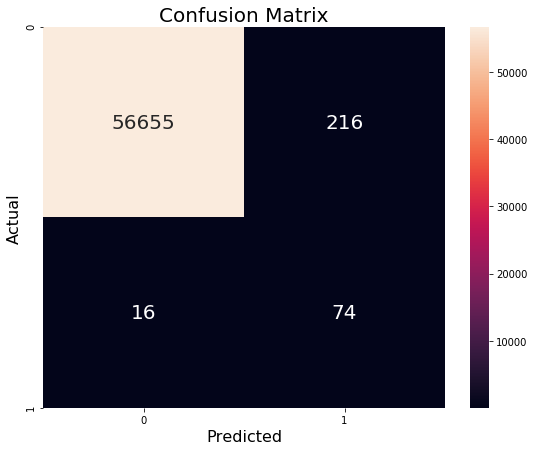

In [100]:
clf_u_opt = LogisticRegression(C=0.01, random_state=0, solver='lbfgs')
clf_u_opt.fit(X_train_u, y_train_u)
probs = clf_u_opt.predict_proba(XX_val)
preds = np.where(probs[:,1] > 0.6, 1, 0)
make_confusion_matrix(y_val, preds)

Finally, we see this model's performance on the test set. It suffices to look at the confusion matrix. Here, we get the following final results for the precision and recall.


$$\text{Final Test With Undersampling:}$$

$$\text{Precision}=\frac{97}{97+209}=31.7\%$$

$$\text{Recall}=\frac{97}{97+12}=89.0\%$$

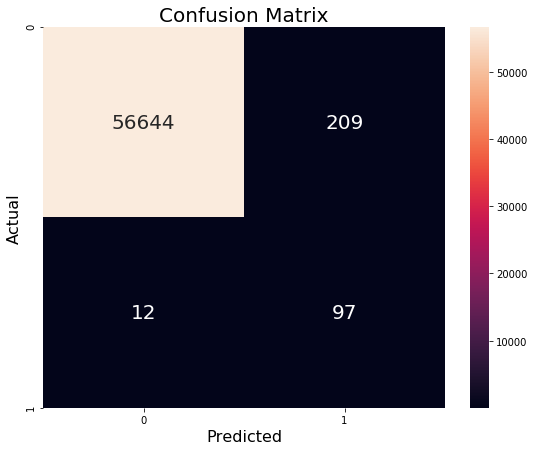

In [101]:
probs_test = clf_u_opt.predict_proba(design_matrix(X_test))
preds_test = np.where(probs_test[:,1] > 0.6, 1, 0)
make_confusion_matrix(y_test, preds_test)

A logistic regression model performs considerably well in detecting fraudulent samples as long as we perform the undersampling method. With undersampling, the recall considerably improves, although precision may decrease as a result. However, as in the test set, we notice that $209/(209+56644)=0.37\%$ of non-fraudulent transactions were flagged falsely as fraud. Of course, we could continue work in order to improve the performance of a classifier that both increases detection and decreases false positives.

For now, we will have to deal with consumers having to appropriately react to an accusation of fraud. However, it is important to note that it may be relatively easy for a consumer to confirm one's own transaction, and thus clear any accusation of fraud.

### References

Blagus, R., Lusa, L. SMOTE for high-dimensional class-imbalanced data. BMC Bioinformatics 14, 106 (2013). https://doi.org/10.1186/1471-2105-14-106